In [1]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

from scipy.spatial.distance import cdist

sns.set()

## 5.12 高斯混合模型
`k-means`聚类模型非常简单并且易于理解，但是在实际应用中，`k-means`的非概率性和它仅根据到簇中心点的距离来指派簇的特点将导致性能低下。`高斯混合模型`可以被看作是`k-means`思想的一个扩展，但它也是一种非常强大的聚类评估工具。

### 5.12.1 高斯混合模型(GMM)为什么会出现：k-means 算法的缺陷
当给定简单且分离性非常好的数据，`k-means`可以找到合适的聚类结果，如`图5-124`：

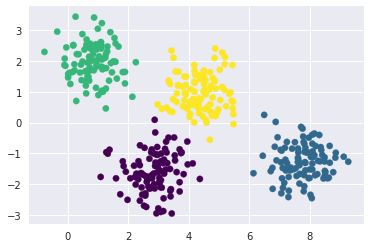

In [2]:
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0) 
X = X[:, ::-1] # 交换列是为了方便画图

kmeans = KMeans(4, random_state=0) 
labels = kmeans.fit(X).predict(X) 
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.show()

如上图所示，某些点的归属簇比其他点的归属簇更加明确。例如，中间的两个簇似乎有一小块区域重合，因此我们对重合部分的点将被分配到哪个簇不是很有信心。不幸的是，`k-means`模型本身也没有度量簇的分配概率或不确定性的方法(虽然可以用数据重抽样方法bootstrap来估计不确定性)。因此，我们必须找到一个更通用的模型。

理解`k-means`模型的一种方法是，它在每个簇的中心放置了一个圆圈(在更高维空间中是一个超空间)，圆圈半径根据最远的点与簇中心点的距离算出。这个半径作为训练集分配簇的`硬切断`(hard cutoff)，即圆圈之外的任何点都不是该簇的成员。用下面这个函数将聚类模型可视化(`图5-125`)：

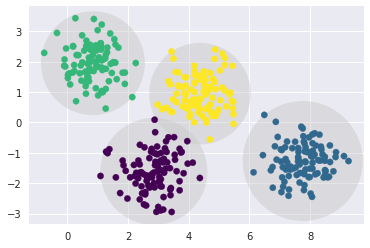

In [3]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    # 画出输入数据 
    ax = ax or plt.gca() 
    ax.axis('equal') 
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # 画出k-means模型的表示 
    centers = kmeans.cluster_centers_ 
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)] 
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0) 
plot_kmeans(kmeans, X)
plt.show()

`k-means`的一个重要特征是要求这些簇的模型必须是圆形，`k-means`算法没有内置的方法来实现椭圆形的簇。因此，如果对同样的数据进行一些转换，簇的分配就会变得混乱(`图5-126`)：

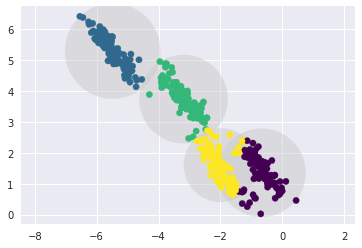

In [4]:
rng = np.random.RandomState(13) 
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0) 
plot_kmeans(kmeans, X_stretched)
plt.show()

通过肉眼观察就可以发现这些变形的簇并不是圆形的，因此圆形的簇拟合效果非常差。`k-means`对这个问题无能为力，只能强行将数据拟合至`4`个圆形的簇，导致多个圆形的簇相互重叠。有人可能会想用`PCA`先预处理数据，从而解决这个特殊的问题。但实际上，`PCA`也不能保证这样的全局操作不会导致单个数据被圆形化。

你可能想通过对`k-means`模型进行一般化处理来弥补这些不足，例如可以通过比较每个点与所有簇中心点的距离来度量簇分配的不确定性，而不仅仅是关注最近的簇；你也可能想通过将簇的边界由圆形放宽至椭圆形，从而得到非圆形的簇。实际上，这正是`高斯混合模型`的两个基本组成部分。

### 5.12.2 一般化`E-M`：高斯混合模型
`高斯混合模型`(Gaussian mixture model，GMM)试图找到多维高斯概率分布的混合体，从而获得任意数据集最好的模型。在最简单的场景中，`GMM可以用与`k-means`相同的方式寻找类(`图5-127`)：

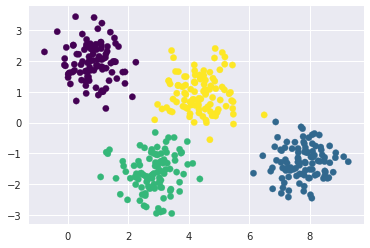

In [5]:
gmm = GaussianMixture(n_components=4).fit(X) 
labels = gmm.predict(X) 
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.show()

`GMM`隐含概率模型，因此可以找出簇分配的概率结果，在`ScikitLearn`中用`predict_proba`方法实现，方法返回一个大小为`[n_samples, n_clusters]`的矩阵，矩阵会给出任意点属于某个簇的概率：

In [6]:
probs = gmm.predict_proba(X) 
probs[:10].round(3)

array([[ 0.   ,  0.469,  0.   ,  0.531],
       [ 0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.014,  0.986],
       [ 0.   ,  0.   ,  1.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   ,  0.   ]])

我们将这个不确定性可视化，点的大小体现预测的不确定性。由`图5-128`可知，在簇边界上的点反映了簇分配的不确定性：

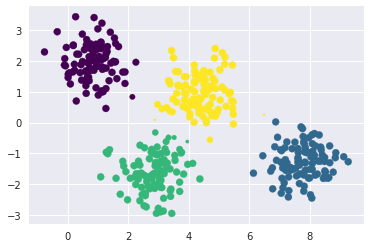

In [7]:
size = 50 * probs.max(1) ** 4 # 平方强调差异 
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size)
plt.show()

高斯混合模型本质上和`k-means`非常类似，它们都使用了期望最大化方法，具体实现如下：
1. 猜测一些簇中心点
2. 重复直至收敛
    1. 期望步骤(`E-step`)：将点分配至离其最近的簇中心点
    2. 最大化步骤(`M-step`)：将簇中心点设置为所有点坐标的平均值
    
结果表明，每个簇的结果并不与`硬边缘的空间`(hard-edged sphere)有关，而是通过高斯平滑模型实现。正如在`k-means`中的期望最大化方法，这个算法有时并不是全局最优解，因此在实际应用需要使用多个随机初始解。

下面创建一个可视化`GMM`簇位置和形状的函数，该函数用`gmm`的输出结果画出椭圆：

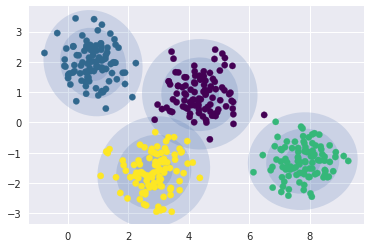

In [8]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)
plt.show()

可以用`GMM`拟合扩展过的数据集。高斯模型允许使用`全协方差`(full covariance)，即使非常扁平的椭圆形的簇，该模型也可以处理(`图5-130`)：

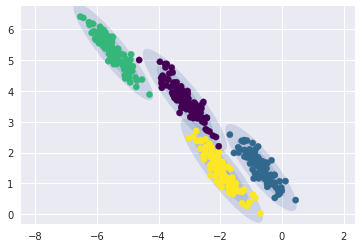

In [9]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42) 
plot_gmm(gmm, X_stretched)
plt.show()

> **选择协方差的类型**
> 
> 之前的每个拟合的`covariance_type`选项的设置是不同的。这个超参数控制了每个簇的形状自由度，非常重要。它的默认设置是`diag`，意思是簇在每个维度的尺寸都可以单独设置，椭圆边界的主轴与坐标轴平行；另一个值`spherical`通过约束簇的形状，让所有维度相等，这样得到的聚类结果和`k-means`聚类的特征是相似的，虽然两者并不完全相同；`full`设置一个更复杂、计算复杂度更高的模型，特别适应于高维度数据，该模型允许每个簇在任意方向上用椭圆建模。

可以用这三种方法可视化同一个聚类数据(`图5-131`)：


### 5.12.3 将GMM用作密度估计
虽然`GMM`通常被归类为聚类算法，但它本质上是一个密度估计算法；也就是说，`GMM`拟合的结果并不是一个`聚类模型`，而是描述数据分布的`生成概率模型`。

用`Scikit-Learn`的`make_moons`函数生成一些数据(`图5-132`)：
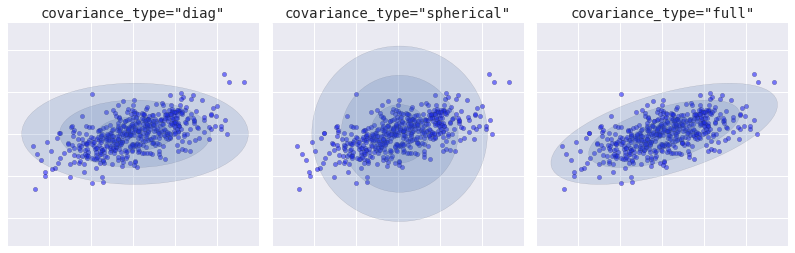

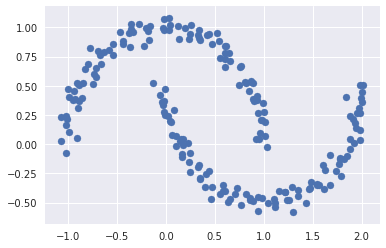

In [10]:
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0) 
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])
plt.show()

如果用`GMM`对数据拟合出两个成分，那么作为一个聚类模型的结果，其实没什么用(`图5-133`)：

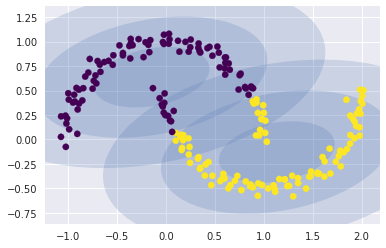

In [11]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0) 
plot_gmm(gmm2, Xmoon)
plt.show()

但如果选用更多的成分而忽视簇标签，就可以找到一个更接近输入数据的拟合结果(`图5-134`)：

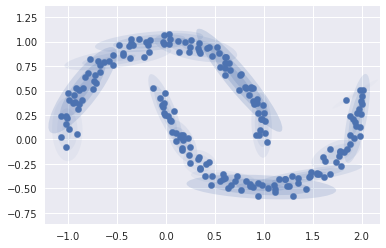

In [12]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0) 
plot_gmm(gmm16, Xmoon, label=False)
plt.show()

这里采用`16`个高斯曲线的混合形式不是为了找到数据的分隔的簇，而是为了对输入数据的总体分布建模。这就是分布函数的生成模型，`GMM`为我们生成新的、与输入数据类似的随机分布函数。例如，下面是用`GMM`拟合原始数据获得的`16`个成分生成的`400`个新数据点(`图5-135`)：

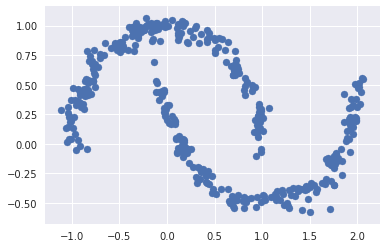

In [13]:
Xnew_tuple = gmm16.sample(400)
Xnew = Xnew_tuple[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1])
plt.show()

`GMM`是一种非常方便的建模方法，可以为数据估计出任意维度的随机分布。

> **需要多少成分？**
> 
> 作为一种生成模型，`GMM`提供了一种确定数据集最优成分数量的方法。由于生成模型本身就是数据集的概率分布，因此可以利用该模型来评估数据的似然估计， 并利用交叉检验防止过拟合。还有一些纠正过拟合的标准分析方法，例如用`赤池信息量准则`(Akaike information criterion，AIC，[link](https://en.wikipedia.org/wiki/Akaike_information_criterion))、`贝叶斯信息准则`(Bayesian information criterion，BIC，[link](https://en.wikipedia.org/wiki/Bayesian_information_criterion))调整模型的似然估计。
 
`Scikit-Learn`的`GMM`评估器已经内置了以上两种度量准则的计算方法，在`GMM`方法中使用它们很方便。

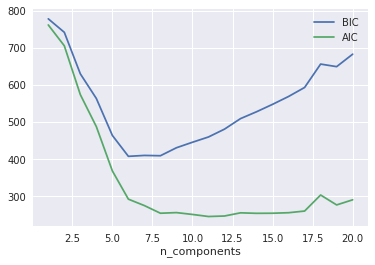

In [14]:
n_components = np.arange(1, 21)

models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) 
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC') 
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC') 
plt.legend(loc='best') 
plt.xlabel('n_components')
plt.show()

类的最优数量出现在`AIC`或`BIC`曲线最小值的位置，最终结果取决于我们更希望使用哪一种近似。`AIC`告诉我们，选择`16`个成分可能太多，`8~12`个成分可能是更好的选择。由于这类经典问题的存在，`BIC`推荐了一个更简单的模型。

这里需要注意的是：成分数量的选择度量的是`GMM`作为一个密度评估器的性能，而不是作为一个聚类算法的性能。建议你还是把`GMM`当成一个密度评估器，仅在简单数据集中才将它作为聚类算法使用。

### 5.12.4 示例：用`GMM`生成新的数据
`GMM`能够根据输入数据的分布创建一个新的样本集。利用这个思路，我们为标准手写数字库生成新的手写数字：

In [15]:
digits = load_digits() 
digits.data.shape

(1797, 64)

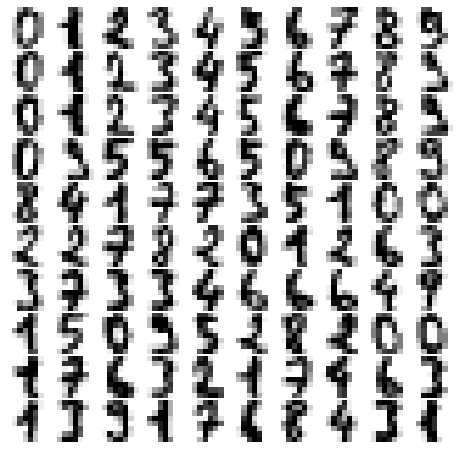

In [16]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8), 
                           subplot_kw=dict(xticks=[], yticks=[])) 
    fig.subplots_adjust(hspace=0.05, wspace=0.05) 
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary') 
        im.set_clim(0, 16) 
        
plot_digits(digits.data)
plt.show()

可以创建一个`GMM`模型来生成更多的数字。`GMM`在这样一个高维空间中可能不太容易收敛，因此先使用一个不可逆的降维算法，用`PCA`保留投影后样本数据`99%`的方差：

In [17]:
pca = PCA(0.99, whiten=True) 
data = pca.fit_transform(digits.data) 
data.shape

(1797, 41)

`PCA`削减了接近`1/3`的维度的同时，几乎没有信息损失。

对这个投影数据使用`AIC`，从而得到`GMM`成分数量的粗略估计(`图5-138`)：

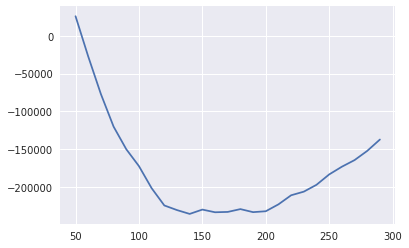

In [18]:
n_components = np.arange(50, 300, 10)

models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components] 
aics = [model.fit(data).aic(data) for model in models] 
plt.plot(n_components, aics)
plt.show()

[**注：这段代码有问题，但是我找不出问题在哪里？！！**]

在大约110个成分的时候，`AIC`是最小的，因此我们使用这个模型：

In [19]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0) 
gmm.fit(data) 
gmm.converged_

True

现在就可以在`41`维投影空间中画出这`100`个点的示例，将`GMM`作为生成模型：

In [20]:
data_new = gmm.sample(100) 
data_new[0].shape

(100, 41)

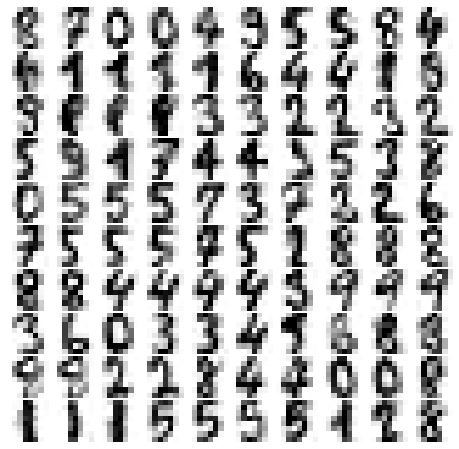

In [21]:
digits_new = pca.inverse_transform(data_new[0]) 
plot_digits(digits_new)
plt.show()

从图中可以看出，大部分数字与原始数据集的数字别无二致。

简单回顾上述操作步骤：首先获得手写数字的示例数据，然后构建该数据的分布模型，最后依据分布模型生成一批新的示例数字。这些`手写数字`并不会单独出现在原始数据集中，而是获取混合模型输入数据的一般特征。这个数字生成模型同时也可以证明，生成模型是贝叶斯生成分类器的一个非常有用的成分，就像下一节将要介绍内容的一样。